In [1]:
import requests
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# User inputs
cpf_current_account_balance = 375.67
cpf_medisave_account_balance = 145.6
cpf_special_account_balance = 90.2

date_of_birth = datetime.datetime(1995, 9, 8)
monthly_salary = 10000
annual_bonus = 15000

goal_age = 55

ageToBuy = 30
houseAmount = 500000.00
downpaymentPct = 0.1
yearsToGo = 30
monthsToGo = yearsToGo*12

cpf_investments = 15674

inflation_rate = 0.01

# Find out CPF Min Sum

In [2]:
date_turning_55 = datetime.datetime(date_of_birth.year + 55, date_of_birth.month, date_of_birth.day)
date_turning_55

datetime.datetime(2050, 9, 8, 0, 0)

In [3]:
def retrieveMinSum(date_turning_55):
    # date_turning_55: datetime.datetime object
    # Returns minimum CPF sum: int
    
    # 55th birthday on or after 1 July for 2003 to 2015, and
    # 1 January from 2017 onwards (no date for 2016)
    retirement_sums_dict = {2002: 0,
                            2003: 80000,
                            2004: 84500,
                            2005: 90000,
                            2006: 94600,
                            2007: 99600,
                            2008: 106000,
                            2009: 117000,
                            2010: 123000,
                            2011: 131000,
                            2012: 139000,
                            2013: 148000,
                            2014: 155000,
                            2015: 161000,
                            2016: 161000,
                            2017: 166000,
                            2018: 171000,
                            2019: 176000,
                            2020: 181000}
    
    min_cpf_sum = min_cpf_sum = retirement_sums_dict[2020]
    if date_turning_55.year < 2003:
        # Before 2003
        min_cpf_sum = 0
    elif date_turning_55.year < 2017:
        # Between 2003 to 2017
        # Check if before or after July
        if date_turning_55.month < 7:
            # Added 2002 in dictionary for corner case where 55th birthday is on 2003 but before July
            min_cpf_sum = retirement_sums_dict[date_turning_55.year - 1]
        else:
            min_cpf_sum = retirement_sums_dict[date_turning_55.year]
    elif date_turning_55.year < 2020:
            min_cpf_sum = retirement_sums_dict[date_turning_55.year]
            
    return min_cpf_sum

In [4]:
min_cpf_sum = retrieveMinSum(date_turning_55)
min_cpf_sum

181000

# (To Generate Chart for Slides)

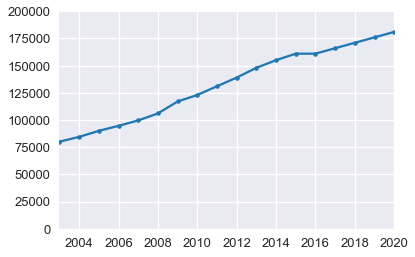

In [5]:
retirement_sums_dict = {2002: 0,
                            2003: 80000,
                            2004: 84500,
                            2005: 90000,
                            2006: 94600,
                            2007: 99600,
                            2008: 106000,
                            2009: 117000,
                            2010: 123000,
                            2011: 131000,
                            2012: 139000,
                            2013: 148000,
                            2014: 155000,
                            2015: 161000,
                            2016: 161000,
                            2017: 166000,
                            2018: 171000,
                            2019: 176000,
                            2020: 181000}

years_list = list(retirement_sums_dict.keys())
retirement_sums_list = list(retirement_sums_dict.values())

sns.set_context("talk")
sns.set_style('darkgrid')

plt.xticks(np.arange(2004, 2021, step=2))
plt.xlim(2003, 2020)
plt.ylim(0, 200000)

plt.plot(years_list[1:], retirement_sums_list[1:], marker='.')

# Get Current Age

In [6]:
def get_current_age(date_of_birth):
    # date_of_birth: datetime.datetime object
    # Returns age: int
    return datetime.datetime.today().year - date_of_birth.year

In [7]:
age = get_current_age(date_of_birth)
age

23

# Determine CPF Contribution

In [8]:
def get_annual_CPF_contribution(date_of_birth, monthly_salary, annual_bonus=0, age=get_current_age(date_of_birth)):
    # date_of_birth: datetime.datetime object
    # monthly_salary: number
    # annual_bonus (optional): number, default 0
    # age (optional): numberm, default current age
    # Returns CPF contribution: number
    
    # Invoke Non-Pension CPF Contribution Calculator
    url = "http://dev.bambu.life:8081/api/CPFContributionCalculator/NonPension"
    querystring = {"date_of_birth": str(date_of_birth.month).zfill(2) + "-" + 
                                       str(date_of_birth.day).zfill(2) + "-" + 
                                       str(datetime.datetime.today().year - age),
                   "ordinary_wage": monthly_salary,
                   "additional_wage": annual_bonus,
                   "non_pensionable_element": "0"}
    response = requests.request("GET", url, params=querystring)
    response = json.loads(response.text)
    return response[0]['TotalCPFContribution'] * 12

In [9]:
cpf_contribution = get_annual_CPF_contribution(date_of_birth, monthly_salary, annual_bonus)
cpf_contribution

32190.0

# Determine CPF Allocation

In [10]:
def get_annual_CPF_allocation(cpf_contribution, date_of_birth, age=get_current_age(date_of_birth)):
    # cpf_contribution: number
    # date_of_birth: datetime.datetime object
    # age (optional): numberm, default current age
    # Returns allocation by account (OA, MA, SA): tuple
    
    # Invoke Non-Pension CPF Allocation Calculator
    url = "http://dev.bambu.life:8081/api/CPFAllocationCalculator/NonPension"
    querystring = {"date_of_birth": str(date_of_birth.month).zfill(2) + "-" + 
                                       str(date_of_birth.day).zfill(2) + "-" + 
                                       str(datetime.datetime.today().year - age),
                   "cpf_contribution": cpf_contribution}
    response = requests.request("GET", url, params=querystring)
    # Calculate amount eligible to be transferred to retirement account
    response = json.loads(response.text)
    oa_ma_sa_tuple = (response[0]['OrdinaryAccount'], response[0]['Medisave'], response[0]['SpecialAccount'])
    
    return oa_ma_sa_tuple

In [11]:
# Calculate amount eligible to be transferred to retirement account
oa_ma_sa_tuple = get_annual_CPF_allocation(cpf_contribution, date_of_birth)
oa_ma_sa_tuple

(20012.523, 6959.478, 5217.999)

# Calculate Predicted Retirement Account Balance

In [12]:
def calculate_cpf_account_balances(date_of_birth,
                                   monthly_salary,
                                   annual_bonus=0,
                                   age_amount_to_deduct=None,
                                   current_balances=(cpf_current_account_balance,
                                                     cpf_medisave_account_balance,
                                                     cpf_special_account_balance),
                                   goal_age=55):
    # date_of_birth: datetime.datetime object
    # monthly_salary: number
    # annual_bonus (optional): number, default: 0
    # age_amount_to_deduct (optional): dictionary of age and amounts to deduct in OA, default: None (null)
    # goal_age: number, age to retire, default: 55
    # Returns cpf allocation by age (int) by account [(OA, MA, SA) - tuple]: dictionary
    
    age = get_current_age(date_of_birth)
    cpf_contribution = get_annual_CPF_contribution(date_of_birth, monthly_salary, annual_bonus)
    oa_ma_sa_tuple = get_annual_CPF_allocation(cpf_contribution, date_of_birth)
    
    predicted_cpf_balances_dict = {0: (0, 0, 0),
                                  age-1: (0, 0, 0),
                                  age: current_balances}
    
    for i in range(age+1, goal_age+1):
        
        if i in [56, 61, 66]:
            # Recalculate CPF contribution
            cpf_contribution = get_annual_CPF_contribution(date_of_birth, monthly_salary, annual_bonus, age=i)

        if i in [36, 46, 51, 56, 61, 66]:
            # Recalculate CPF allocation
            oa_ma_sa_tuple = get_annual_CPF_allocation(cpf_contribution, date_of_birth, age=i)
        
        amount_to_deduct = 0
        
        if age_amount_to_deduct != None:
            amount_to_deduct = age_amount_to_deduct[i]
        
        previous_oa_ma_sa_tuple = predicted_cpf_balances_dict[i - 1]
        predicted_cpf_balances_dict[i] = (previous_oa_ma_sa_tuple[0] + oa_ma_sa_tuple[0] - amount_to_deduct,
                                          previous_oa_ma_sa_tuple[1] + oa_ma_sa_tuple[1],
                                          previous_oa_ma_sa_tuple[2] + oa_ma_sa_tuple[2])
        # print(predicted_cpf_balances_dict[i])
    
    return predicted_cpf_balances_dict

def calculate_ra_account_balances(date_of_birth,
                                  monthly_salary,
                                  annual_bonus=0,
                                  age_amount_to_deduct=None,
                                  current_balances=(cpf_current_account_balance,
                                                    cpf_medisave_account_balance,
                                                    cpf_special_account_balance),
                                  goal_age=55):
    # date_of_birth: datetime.datetime object
    # monthly_salary: number
    # annual_bonus (optional): number, default: 0
    # age_amount_to_deduct (optional): dictionary of age and amounts to deduct in OA, default None (null)
    # goal_age: number, age to retire, default: 55
    # Returns predicted RA account balance (number) by age (int): dictionary
    
    predicted_ra_balances_dict = calculate_cpf_account_balances(date_of_birth,
                                                                monthly_salary,
                                                                annual_bonus=annual_bonus,
                                                                age_amount_to_deduct=age_amount_to_deduct,
                                                                current_balances=current_balances,
                                                                goal_age=goal_age)
    
    for i in predicted_ra_balances_dict.keys():
        predicted_ra_balances_dict[i] = (predicted_ra_balances_dict[i][0] + 
                                         predicted_ra_balances_dict[i][2])
    
    return predicted_ra_balances_dict

In [13]:
predicted_ra_balances_dict = calculate_ra_account_balances(date_of_birth, monthly_salary, annual_bonus, goal_age=goal_age)
predicted_ra_balances_dict

{0: 0,
 22: 0,
 23: 465.87,
 24: 25696.392,
 25: 50926.914000000004,
 26: 76157.436,
 27: 101387.958,
 28: 126618.48000000001,
 29: 151849.002,
 30: 177079.524,
 31: 202310.04599999997,
 32: 227540.56799999997,
 33: 252771.08999999997,
 34: 278001.61199999996,
 35: 303232.1339999999,
 36: 327593.52599999995,
 37: 351954.91799999995,
 38: 376316.30999999994,
 39: 400677.7019999999,
 40: 425039.09399999987,
 41: 449400.48599999986,
 42: 473761.8779999998,
 43: 498123.2699999998,
 44: 522484.6619999998,
 45: 546846.0539999998,
 46: 570338.3159999998,
 47: 593830.5779999997,
 48: 617322.8399999997,
 49: 640815.1019999997,
 50: 664307.3639999997,
 51: 687365.0609999996,
 52: 710422.7579999997,
 53: 733480.4549999997,
 54: 756538.1519999998,
 55: 779595.8489999998}

# Plot graph

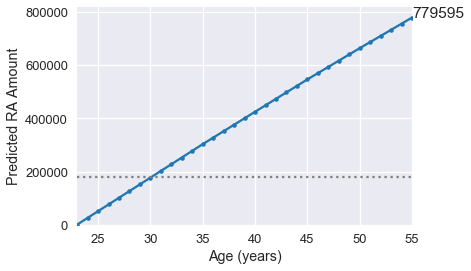

In [14]:
sns.set_context("talk")
sns.set_style('darkgrid')

plt.plot(predicted_ra_balances_dict.keys(), predicted_ra_balances_dict.values(), marker='.')
plt.xlim(age, goal_age)
plt.ylim(0)
plt.annotate(s=int(predicted_ra_balances_dict[goal_age]), xy=(goal_age, predicted_ra_balances_dict[goal_age]))
plt.xlabel('Age (years)')
plt.ylabel('Predicted RA Amount')
plt.axhline(y = min_cpf_sum, color='gray', ls=':')

In [15]:
min_sum = retrieveMinSum(date_turning_55)
if list(predicted_ra_balances_dict.values())[-1] - min_sum >= 0:
    print("You can achieve the minimum sum of " + str(min_sum))
else:
    print("You cannot achieve the minimum sum of " + str(min_sum))

You can achieve the minimum sum of 181000


In [16]:
def calculate_mortgage(house_amount, months_to_go, downpayment_pct):
    url = "http://microservice.dev.bambu.life/api/generalCalculator/mortgageCalculators"
    payload = {"houseAmount":str(house_amount),
               "downpaymentPct":str(downpayment_pct),
               "monthsToGo":str(months_to_go)}
    
    response = requests.request("POST", url, data=payload)
    response = json.loads(response.text)
    return response['response']

def calculate_mortgage_downpayment(house_amount, months_to_go, downpayment_pct=0.1):
    response = calculate_mortgage(house_amount=house_amount, months_to_go=months_to_go, downpayment_pct=downpayment_pct)
    return response['downpayment']

def calculate_mortgage_min_monthly_payment(house_amount, months_to_go, downpayment_pct=0.1):
    response = calculate_mortgage(house_amount=house_amount, months_to_go=months_to_go, downpayment_pct=downpayment_pct)
    return response['minMonthlyPayment']

In [17]:
downpayment = calculate_mortgage_downpayment(houseAmount, monthsToGo)
minMonthlyPayment = calculate_mortgage_min_monthly_payment(houseAmount, monthsToGo)

print(downpayment)
print(minMonthlyPayment)

50000
1807.8005559058054


In [18]:
def calculate_mortgage_cpf_payments(house_amount, months_to_go, age_to_buy, downpayment_pct=0.1):
    downpayment = calculate_mortgage_downpayment(house_amount, months_to_go)
    minMonthlyPayment = calculate_mortgage_min_monthly_payment(house_amount, months_to_go)

    capCPF = 1.2 * houseAmount
    totalAmount = downpayment + minMonthlyPayment * monthsToGo

    from collections import defaultdict
    payment = defaultdict(int)

    payment[ageToBuy] = downpayment * 0.75
    
    for i in range(0, yearsToGo - 1):
        for j in range(1, 12):
            amount = payment[i + ageToBuy]
            payment[i + ageToBuy] = amount + minMonthlyPayment 
            capCPF = capCPF - minMonthlyPayment

            if capCPF < 0:
                break
        # print (capCPF)
        if capCPF < 0:
            break
    
    return payment

In [19]:
mortgage_payments_dict = calculate_mortgage_cpf_payments(houseAmount, monthsToGo, ageToBuy)
mortgage_payments_dict

defaultdict(int,
            {30: 57385.80611496388,
             31: 19885.806114963856,
             32: 19885.806114963856,
             33: 19885.806114963856,
             34: 19885.806114963856,
             35: 19885.806114963856,
             36: 19885.806114963856,
             37: 19885.806114963856,
             38: 19885.806114963856,
             39: 19885.806114963856,
             40: 19885.806114963856,
             41: 19885.806114963856,
             42: 19885.806114963856,
             43: 19885.806114963856,
             44: 19885.806114963856,
             45: 19885.806114963856,
             46: 19885.806114963856,
             47: 19885.806114963856,
             48: 19885.806114963856,
             49: 19885.806114963856,
             50: 19885.806114963856,
             51: 19885.806114963856,
             52: 19885.806114963856,
             53: 19885.806114963856,
             54: 19885.806114963856,
             55: 19885.806114963856,
             56: 19885

In [20]:
predicted_ra_balances_dict = calculate_ra_account_balances(date_of_birth, monthly_salary, annual_bonus, mortgage_payments_dict)
predicted_ra_balances_dict

{0: 0,
 22: 0,
 23: 465.87,
 24: 25696.392,
 25: 50926.914000000004,
 26: 76157.436,
 27: 101387.958,
 28: 126618.48000000001,
 29: 151849.002,
 30: 119693.71788503612,
 31: 125038.43377007227,
 32: 130383.14965510841,
 33: 135727.86554014456,
 34: 141072.58142518072,
 35: 146417.29731021685,
 36: 150892.88319525297,
 37: 155368.46908028913,
 38: 159844.05496532528,
 39: 164319.6408503614,
 40: 168795.22673539753,
 41: 173270.8126204337,
 42: 177746.39850546984,
 43: 182221.98439050597,
 44: 186697.5702755421,
 45: 191173.15616057825,
 46: 194779.6120456144,
 47: 198386.06793065055,
 48: 201992.5238156867,
 49: 205598.97970072285,
 50: 209205.435585759,
 51: 212377.32647079515,
 52: 215549.2173558313,
 53: 218721.1082408674,
 54: 221892.99912590356,
 55: 225064.8900109397}

In [21]:
mortgage_payments_dict = calculate_mortgage_cpf_payments(houseAmount, monthsToGo, ageToBuy)
mortgage_payments_dict

defaultdict(int,
            {30: 57385.80611496388,
             31: 19885.806114963856,
             32: 19885.806114963856,
             33: 19885.806114963856,
             34: 19885.806114963856,
             35: 19885.806114963856,
             36: 19885.806114963856,
             37: 19885.806114963856,
             38: 19885.806114963856,
             39: 19885.806114963856,
             40: 19885.806114963856,
             41: 19885.806114963856,
             42: 19885.806114963856,
             43: 19885.806114963856,
             44: 19885.806114963856,
             45: 19885.806114963856,
             46: 19885.806114963856,
             47: 19885.806114963856,
             48: 19885.806114963856,
             49: 19885.806114963856,
             50: 19885.806114963856,
             51: 19885.806114963856,
             52: 19885.806114963856,
             53: 19885.806114963856,
             54: 19885.806114963856,
             55: 19885.806114963856,
             56: 19885

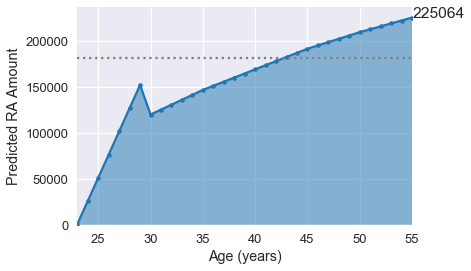

In [22]:
sns.set_context("talk")
sns.set_style('darkgrid')

plt.plot(predicted_ra_balances_dict.keys(), predicted_ra_balances_dict.values(), marker='.')
plt.xlim(age, 55)
plt.ylim(0)
plt.annotate(s=int(predicted_ra_balances_dict[goal_age]), xy=(goal_age, predicted_ra_balances_dict[goal_age]))
plt.xlabel('Age (years)')
plt.ylabel('Predicted RA Amount')
plt.fill_between(predicted_ra_balances_dict.keys(), predicted_ra_balances_dict.values(), alpha=0.5)
plt.axhline(y = min_cpf_sum, color='gray', ls=':')

In [23]:
labels = ['Housing', 'Insurance', 'CPF investments']
values = [sum(mortgage_payments_dict.values()) / len(mortgage_payments_dict.values()), 10000, cpf_investments]
values

[21178.90956323971, 10000, 15674]

(-2.245961029183002,
 2.202188620437286,
 -2.2045202783005715,
 2.2516920661938147)

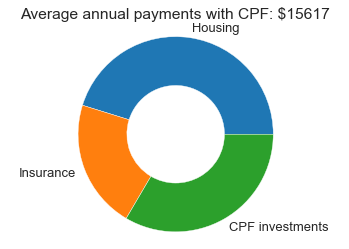

In [24]:
plt.pie(values, labels=labels, radius=2, wedgeprops=dict(width=1, edgecolor='w'))
plt.title("Average annual payments with CPF: $" + str(int(sum(values)/len(values))))
plt.axis("equal")

In [25]:
def get_current_monthly_expense_prediction(monthly_salary):
    url = "http://dev.bambu.life:8081/api/TotalExpenseEstimator"
    querystring = {"monthly_income":str(monthly_salary)}
    
    response = requests.request("GET", url, params=querystring)

    return float(response.text)

In [32]:
current_monthly_expense_prediction = get_current_monthly_expense_prediction(monthly_salary)
current_monthly_expense_prediction

2302.0

In [35]:
def get_future_monthly_expense(monthly_expense_prediction, age, inflation_rate, retirement_goal_age):
    url = "http://dev.bambu.life:8081/api/MonthlyRetirementIncomeCalculator"
    querystring = {"monthly_expense": str(monthly_expense_prediction),
                   "age": str(age),
                   "inflation_rate": str(inflation_rate),
                   "retirement_age":str(retirement_goal_age)}

    response = requests.request("GET", url, params=querystring)

    return float(response.text)

In [36]:
monthly_expense_prediction = get_future_monthly_expense(current_monthly_expense_prediction, age, inflation_rate, goal_age)
monthly_expense_prediction

3165.1134419785863